2025-05-04 10:13:48.171779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746353628.361394      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746353628.421842      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 4768 validated image filenames belonging to 4 classes.
Found 1022 validated image filenames belonging to 4 classes.
Found 1022 validated image filenames belonging to 4 classes.


I0000 00:00:1746353652.584857      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746353763.478633      89 service.cc:148] XLA service 0x78e098004280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746353763.479441      89 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746353771.801004      89 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1746353785.469895      89 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746353785.666399      89 gpu_timer.cc:

149/149 ━━━━━━━━━━━━━━━━━━━━ 468s 2s/step - accuracy: 0.5852 - loss: 1.2043 - val_accuracy: 0.0548 - val_loss: 1.6354 - learning_rate: 1.0000e-04
Epoch 2/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.8756 - loss: 0.3456 - val_accuracy: 0.1673 - val_loss: 1.5628 - learning_rate: 1.0000e-04
Epoch 3/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.9326 - loss: 0.2096 - val_accuracy: 0.2348 - val_loss: 2.0635 - learning_rate: 1.0000e-04
Epoch 4/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.9426 - loss: 0.1539 - val_accuracy: 0.6624 - val_loss: 1.2671 - learning_rate: 1.0000e-04
Epoch 5/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.9651 - loss: 0.1015 - val_accuracy: 0.8718 - val_loss: 0.4555 - learning_rate: 1.0000e-04
Epoch 6/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.9654 - loss: 0.1102 - val_accuracy: 0.9560 - val_loss: 0.1491 - learning_rate: 1.0000e-04
32/32 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.9509 - loss: 0.1333



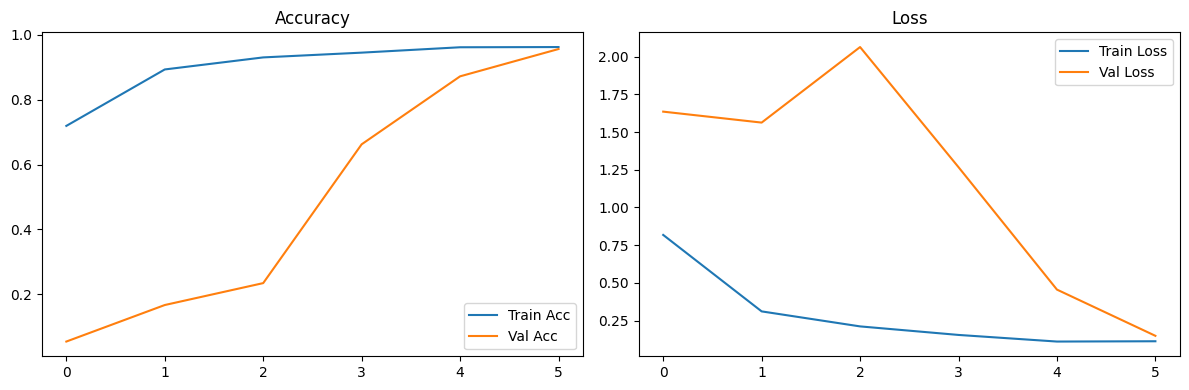

Model saved to /kaggle/working/poultry_model.h5


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 6
LEARNING_RATE = 1e-4
FINE_TUNE_LEARNING_RATE = 1e-5
FINE_TUNE_EPOCHS = 3

def prepare_generic_data(dataset_path):
    image_paths = []
    labels = []
    
    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(class_name, img_file))
                    labels.append(class_name)
    
    df = pd.DataFrame({'filename': image_paths, 'label': labels})
    train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=25,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=dataset_path,
        x_col='filename',
        y_col='label',
        target_size=IMG_SIZE,
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    
    val_gen = val_test_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory=dataset_path,
        x_col='filename',
        y_col='label',
        target_size=IMG_SIZE,
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    
    test_gen = val_test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=dataset_path,
        x_col='filename',
        y_col='label',
        target_size=IMG_SIZE,
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_gen.classes),
        y=train_gen.classes
    )
    class_weights = dict(enumerate(class_weights))
    
    return train_gen, val_gen, test_gen, len(train_gen.class_indices), class_weights

def create_model(input_shape, num_classes):
    base_model = tf.keras.applications.EfficientNetB3(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )
    
    x = base_model.output
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=base_model.input, outputs=predictions)
    
    return model

def train_model(dataset_path):
    train_gen, val_gen, test_gen, num_classes, class_weights = prepare_generic_data(dataset_path)
    
    model = create_model(IMG_SIZE + (3,), num_classes)
    
    model.compile(
        optimizer=Adam(LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    ]
    
    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=val_gen,
        callbacks=callbacks,
        class_weight=class_weights
    )
    
    model.trainable = True
    
    model.compile(
        optimizer=Adam(FINE_TUNE_LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history_fine = model.fit(
        train_gen,
        epochs=FINE_TUNE_EPOCHS,
        initial_epoch=history.epoch[-1],
        validation_data=val_gen,
        callbacks=callbacks,
        class_weight=class_weights
    )
    
    full_history = {
        'accuracy': history.history.get('accuracy', []) + history_fine.history.get('accuracy', []),
        'val_accuracy': history.history.get('val_accuracy', []) + history_fine.history.get('val_accuracy', []),
        'loss': history.history.get('loss', []) + history_fine.history.get('loss', []),
        'val_loss': history.history.get('val_loss', []) + history_fine.history.get('val_loss', [])
    }
    
    test_loss, test_acc = model.evaluate(test_gen)
    print(f'\n Test accuracy: {test_acc:.2f}')
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(full_history['accuracy'], label='Train Acc')
    plt.plot(full_history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(full_history['loss'], label='Train Loss')
    plt.plot(full_history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model

# Run training on Kaggle
DATASET_PATH = "/kaggle/input/poultry-diseases-detection/poultry_diseases"
model = train_model(DATASET_PATH)
model.save("/kaggle/working/poultry_model.h5")
print("Model saved to /kaggle/working/poultry_model.h5")
